# ML_CyberAttack Predictor project


Import libraries :
link to ua-parser library : https://github.com/ua-parser/uap-python



In [103]:
import pandas as pd
from pyexpat import features
from uaparser import UAParser as parse_ua


# DATA CLEAN

In [104]:
dataset_path = 'Data/cybersecurity_attacks.csv'
df = pd.read_csv(dataset_path)
df.head()

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


## Device Information
Device information column return the user agent information or the destination address \
User-agent provide information about the devices : OS, Browsers and device type and brand \
#### **Observation** :
ua-string is unusable as it is an aggregation of string values. Furthermore, some information  \
could lead to confusion as the prefix which could be interpreted as the browser, but which \
is in fact the compatibility of the rendering browser engine. \
*Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like Mac OS X; tg-TJ) AppleWebKit/534.33.5 (KHTML, like Gecko) Version/4.0.5 Mobile/8B116 Safari/6534.33.5*  \
For instance this ua above refer to an ipod with Safari browser version as 4.0.5. and an Iphone OS 3.0
#### *Data cleaning*
Extraction of the name and version of the OS, Browser and the type of device to figure out if one is susceptible to \
a specific attack. \
In order to do so, we decide to use the library ua_parser to extract relevant information.  \



In [105]:
"""
Function implementations to parse os,browser and devices
version_os and browser return concatenation of name major_version
"""
def version_os(row):
    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    os_name = parsed_ua.os['name']
    os_version = parsed_ua.os['version']
    version = os_version.split(".")[0] # return the major of the version (first numbers)

    return f"{os_name} {version}"

def version_browser(row):

    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    browser_name = parsed_ua.browser['name']
    browser_version = parsed_ua.browser['version']
    version = browser_version.split(".")[0]

    return f"{browser_name} {version}"

def type_device(row):

    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    device_type = parsed_ua.device['type']
    if device_type is None:
        device_type = "computer"
    return device_type

"""
Create columns by applying the function
"""

df['version_os'] = df.apply(version_os, axis=1)
df['version_browser'] = df.apply(version_browser, axis=1)
df['type_device'] = df.apply(type_device, axis=1)

*Add date information*
Import list_os_browsers.xlsx which contains launch and end_of_care date to OS and browsers in order to compute
- a categorical data : end_of_care which allocates 1 to OS with end of care date
- a numeric hierarchic field : date of OS and browser compared to attack type

In [106]:
#Import tables for OS, Browsers
df_browser_list = pd.read_excel('Data/list_os_ browsers.xlsx', sheet_name='EOC BW')
df_OS_list = pd.read_excel('Data/list_os_ browsers.xlsx', sheet_name='EOC OS')
"""
OS version
"""
#Compute the mean to fill the null values
print(df_OS_list['Date de sortie'].mean().round())
print(df_OS_list['Date de fin de support'].mean().round())
# Merge the table OS
df = df.merge(df_OS_list, how='left', left_on="version_os", right_on="Système d'exploitation")
#Fill NaN with the associate mean
df['Date de sortie'] = df['Date de sortie'].fillna(2011)
df['Date de fin de support'] = df['Date de fin de support'].fillna(2016)
#Create year_attack column in order to compare with date of end_of_care
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year_attack'] = df['Timestamp'].dt.year
df['os_EndOfCare'] = df.apply(lambda row: 0 if row['year_attack'] < row['Date de fin de support'] else 1, axis=1)
df['os_yold'] = df['year_attack']-df['Date de sortie']
"""
Browser version
"""
df = df.merge(df_browser_list, how='left', left_on="version_browser", right_on= "Bibliothèque")

#Compute the mean to fill the null values
print(df_browser_list ['Date de sortie'].mean().round())
print(df_browser_list ['Date de fin de support'].mean().round())
df['Date de sortie_Brw'] = df['Date de sortie_y'].fillna(2014)
df['Date de fin de support_Brw'] = df['Date de fin de support_y'].fillna(2015)
#compare with date of end_of_care
df['Browser_EndOfCare'] = df.apply(lambda row: 0 if row['year_attack'] < row['Date de fin de support_Brw'] else 1, axis=1)
df['Browser_yold'] = df['year_attack']-df['Date de sortie_Brw']
df_date = df

2011.0
2016.0
2014.0
2015.0


#### *Data cleaning*
Cleaning the dataset after adding information

In [107]:
#drop useless columns
columns_to_drop = ["Geo-location Data","Version_x","Date de sortie_x","Date de fin de support_x","year_attack","Navigateur","Bibliothèque","Version_y","Date de sortie_y","Date de fin de support_y","Système d\'exploitation_y","Date de sortie_Brw","Date de fin de support_Brw"]
df =df.drop(columns_to_drop,axis=1)

df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,IDS/IPS Alerts,Log Source,version_os,version_browser,type_device,Système d'exploitation_x,os_EndOfCare,os_yold,Browser_EndOfCare,Browser_yold
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,NaN,Server,Windows 8,IE 8,computer,Windows 8,1,11.0,1,22.0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,NaN,Firewall,Windows Vista,IE 8,computer,Windows Vista,1,13.0,1,19.0
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Alert Data,Firewall,Windows 8,IE 9,computer,Windows 8,0,10.0,1,16.0
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Alert Data,Firewall,Mac OS 10,Firefox 11,computer,Mac OS 10,1,7.0,1,11.0
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Alert Data,Firewall,Windows 8,IE 5,computer,Windows 8,1,11.0,1,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accus...,...,Alert Data,Firewall,iOS 14,Firefox 17,tablet,iOS 14,1,3.0,1,11.0
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commo...,...,NaN,Firewall,Windows 98,Safari 4,computer,Windows 98,1,25.0,1,14.0
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligen...,...,Alert Data,Server,Windows NT 4,Safari 4,computer,Windows NT 4,1,26.0,1,13.0
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,2703,UDP,483,Data,FTP,Officiis dolorem sed harum provident earum dis...,...,NaN,Server,Linux i686,Chrome 15,computer,NaN,1,12.0,1,12.0


# Data Analysis
## Analyse timestamp

In [108]:
'''df_timestamp = df['Timestamp'].to_timestamp()'''
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['hour'] = df['Timestamp'].dt.hour
def night(hour):
    if hour > 22 or hour < 6:
        return 1
    else:
        return 0
df['night'] = df['hour'].apply( lambda hour: night(hour))


##

Add OS name(brand)

In [109]:
def version_os_name(row):
    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    os_name = parsed_ua.os['name']
    return os_name
df['version_os_name'] = df.apply(version_os_name, axis=1)

### Users already attacked

In [110]:
#Create a series of users that have been attacked several times
user_nb_attack = df['User Information'].value_counts()
attacked = user_nb_attack[user_nb_attack > 1].index
def attacked_users(row):
    if row['User Information'] in attacked:
        return 1
    else:
        return 0
df['attacked'] = df.apply(lambda row: attacked_users(row), axis=1)
df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,type_device,Système d'exploitation_x,os_EndOfCare,os_yold,Browser_EndOfCare,Browser_yold,hour,night,version_os_name,attacked
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,computer,Windows 8,1,11.0,1,22.0,6,0,Windows,0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,computer,Windows Vista,1,13.0,1,19.0,7,0,Windows,1
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,computer,Windows 8,0,10.0,1,16.0,8,0,Windows,0
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,computer,Mac OS 10,1,7.0,1,11.0,10,0,Mac OS,0
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,computer,Windows 8,1,11.0,1,24.0,13,0,Windows,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accus...,...,tablet,iOS 14,1,3.0,1,11.0,14,0,iOS,0
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commo...,...,computer,Windows 98,1,25.0,1,14.0,0,1,Windows,0
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligen...,...,computer,Windows NT 4,1,26.0,1,13.0,1,1,Windows,1
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,2703,UDP,483,Data,FTP,Officiis dolorem sed harum provident earum dis...,...,computer,NaN,1,12.0,1,12.0,18,0,Linux,1


## Feature Engineering


### Binning values into discrete intervals or binary

Port are bin into the Iana category :
https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.xhtml

In [111]:
def categorize_port(port):
    if 0 <= port <= 1023:
        return 'SystemPorts'
    elif 1024 <= port <= 49151:
        return 'UserPorts'
    elif 49152 <= port <= 65535:
        return 'Dynamic'
    else:
        return 'Unk'


df['Destination Port'] = df['Destination Port'].apply(categorize_port)

In [112]:
import numpy as np
df['packet_length_bins'] = pd.cut(df['Packet Length'], bins=[0, 100, 500, 1500, np.inf], labels=["very small", "small", "medium", "large"])
df =df.drop('Packet Length', axis=1)

In [113]:
def proxyOn(row):
    if pd.isna(row):
        return 0
    else:
        return 1


df['ProxyON'] = df.apply(lambda row: proxyOn(row['Proxy Information']), axis=1)
df.drop('Proxy Information', axis=1)
def FireOn(row):
    if pd.isna(row):
        return 0
    else:
        return 1


df['FireOn'] = df.apply(lambda row: proxyOn(row['Firewall Logs']), axis=1)
df.drop('Firewall Logs', axis=1)
def IDP_IPS_On(row):
    if pd.isna(row):
        return 0
    else:
        return 1


df['IDP/IPS On'] = df.apply(lambda row: proxyOn(row['IDS/IPS Alerts']), axis=1)
df =df.drop('IDS/IPS Alerts', axis=1)

### Ordinal encoding

In [114]:
#Severity Level
severity_mapping = {'High': 3, 'Medium': 2, 'Low': 1}
df['Severity Level score'] = df['Severity Level'].map(severity_mapping)
#Malware Indicators
malware_mapping = {'IoC Detected': 1, 'not_detected': 0}
df['MalwareDetect'] = df['Malware Indicators'].map(malware_mapping).fillna(0)
#Alerts
alert_mapping = {'Alert Triggered': 1, 'not_detected': 0}
df['Alert'] = df['Alerts/Warnings'].map(alert_mapping).fillna(0)

In [115]:
columns_to_drop2 = ["Payload Data","Malware Indicators","Alerts/Warnings","Severity Level","User Information","Device Information","Proxy Information","Firewall Logs","version_os","version_browser","Système d\'exploitation_x","hour","Timestamp","type_device"]
df = df.drop(columns_to_drop2, axis=1)
df

,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Type,Traffic Type,Anomaly Scores,Attack Type,Attack Signature,...,night,version_os_name,attacked,packet_length_bins,ProxyON,FireOn,IDP/IPS On,Severity Level score,MalwareDetect,Alert
0,103.216.15.12,84.9.164.252,31225,UserPorts,ICMP,Data,HTTP,28.67,Malware,Known Pattern B,...,0,Windows,0,medium,1,1,0,1,1.0,0.0
1,78.199.217.198,66.191.137.154,17245,UserPorts,ICMP,Data,HTTP,51.50,Malware,Known Pattern A,...,0,Windows,1,medium,0,1,0,1,1.0,0.0
2,63.79.210.48,198.219.82.17,16811,Dynamic,UDP,Control,HTTP,87.42,DDoS,Known Pattern B,...,0,Windows,0,small,1,1,1,1,1.0,1.0
3,163.42.196.10,101.228.192.255,20018,UserPorts,UDP,Data,HTTP,15.79,Malware,Known Pattern B,...,0,Mac OS,0,small,0,0,1,2,0.0,1.0
4,71.166.185.76,189.243.174.238,6131,UserPorts,TCP,Data,DNS,0.52,DDoS,Known Pattern B,...,0,Windows,0,medium,1,0,1,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,26.36.109.26,121.100.75.240,31005,UserPorts,UDP,Control,HTTP,39.28,DDoS,Known Pattern A,...,0,iOS,0,medium,0,1,1,2,1.0,0.0
39996,17.21.163.81,196.108.134.78,2553,UserPorts,UDP,Control,HTTP,27.25,DDoS,Known Pattern A,...,1,Windows,0,medium,1,1,0,3,1.0,0.0
39997,162.35.217.57,98.107.0.15,22505,UserPorts,UDP,Data,DNS,31.01,DDoS,Known Pattern B,...,1,Windows,1,medium,0,1,1,1,1.0,0.0
39998,208.72.233.205,173.79.112.252,20013,UserPorts,UDP,Data,FTP,97.85,Malware,Known Pattern B,...,0,Linux,1,small,1,1,0,1,1.0,1.0


# ML

In [116]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

In [117]:
'''
features = ['Anomaly Scores','Severity Level score','Protocol', 'Traffic Type', 'ProxyON','attacked', 'Destination Port']
numerical_features  =['Anomaly Scores','Severity Level score']
categorical_features  =  ['Protocol', 'Traffic Type', 'ProxyON','attacked', 'Destination Port']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


df_scaled = preprocessor.fit_transform(df[features])

kmeans = KMeans(n_clusters=12, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)
correlations = df.select_dtypes(include=np.number).corr()['Cluster']
print("Corrélations avec l’affectation aux cluster:")
print(correlations)
'''

Corrélations avec l’affectation aux cluster:
Source Port            -0.001187
Anomaly Scores         -0.388644
os_EndOfCare            0.005246
os_yold                 0.002180
Browser_EndOfCare            NaN
Browser_yold           -0.000666
night                  -0.000828
attacked                0.097391
ProxyON                 0.124814
FireOn                  0.003038
IDP/IPS On             -0.008664
Severity Level score   -0.189774
MalwareDetect           0.001818
Alert                   0.002945
Cluster                 1.000000
Name: Cluster, dtype: float64


In [118]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [148]:
features = ["Protocol",'Severity Level score', 'Traffic Type', 'ProxyON','attacked', 'Destination Port',"packet_length_bins","os_yold",'night',"Network Segment"]
numerical_features  =['Severity Level score',"os_yold"]
categorical_features  =  ["Protocol",'Traffic Type', 'ProxyON','attacked', 'Destination Port',"packet_length_bins",'night',"Network Segment"]

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


Accuracy: 0.341375
              precision    recall  f1-score   support

        DDoS       0.34      0.35      0.34      2636
   Intrusion       0.34      0.32      0.33      2721
     Malware       0.35      0.36      0.35      2643

    accuracy                           0.34      8000
   macro avg       0.34      0.34      0.34      8000
weighted avg       0.34      0.34      0.34      8000



## Visualization

Palette creation for visual
color selection : https://colorbrewer2.org/#

In [120]:
import seaborn as sns
palette_os = ['#ca0020','#f4a582','#ffffff','#bababa','#404040']
sns.set_palette(palette_os)


### Data

In [121]:
import matplotlib.pyplot as plt


<Axes: xlabel='Attack Type', ylabel='version_os_name'>

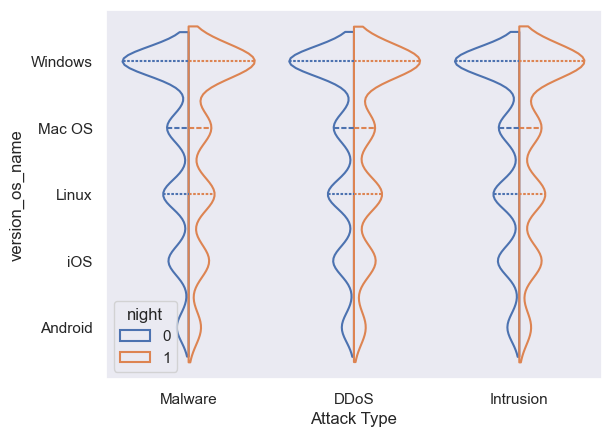

In [122]:
sns.set_theme(style="dark")

sns.violinplot(data=df, x="Attack Type", y="version_os_name", hue="night",
               split=True, inner="quart", fill=False)

In [123]:
df_view = df
def version_os_name(row):
    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    os_name = parsed_ua.os['name']
    return os_name

def version_browser_name(row):
    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    browser_name = parsed_ua.browser['name']
    return browser_name

def type_device(row):
    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    device_type = parsed_ua.device['type']
    if device_type is None:
        device_type = "computer" # for null value force as 'computer'
    return device_type

df_view['version_os_name'] = df_view.apply(version_os_name, axis=1)
df_view['version_browser_name'] = df_view.apply(version_browser_name, axis=1)
df_view['type_device'] = df_view.apply(type_device, axis=1)


KeyError: 'Device Information'

In [80]:
dict_os = df_view['version_os_name'].value_counts().to_dict()
data = dict_os.values()
labels = dict_os.keys()
print(data)
print(labels)

dict_values([17953, 7171, 5813, 5774, 3289])
dict_keys(['Windows', 'Linux', 'Mac OS', 'iOS', 'Android'])


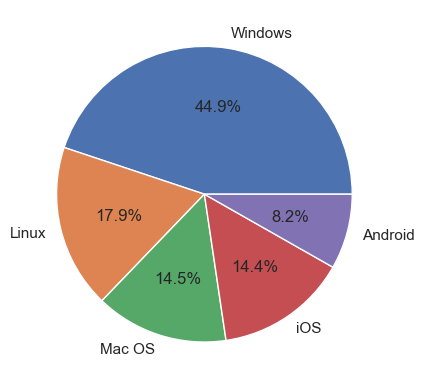

In [81]:
plot = plt.pie(data, labels=labels, autopct='%1.1f%%',colors =sns.color_palette())

In [82]:
df_date

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Navigateur,Bibliothèque,Version_y,Date de sortie_y,Date de fin de support_y,Système d'exploitation_y,Date de sortie_Brw,Date de fin de support_Brw,Browser_EndOfCare,Browser_yold
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Internet Explorer,IE 8,8.0,2001.0,2009.0,Windows,2001.0,2009.0,1,22.0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Internet Explorer,IE 8,8.0,2001.0,2009.0,Windows,2001.0,2009.0,1,19.0
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Internet Explorer,IE 9,9.0,2006.0,2011.0,Windows,2006.0,2011.0,1,16.0
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Fire Fox,Firefox 11,11.0,2012.0,2012.0,Windows et MAC et LINUX,2012.0,2012.0,1,11.0
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Internet Explorer,IE 5,5.0,1999.0,2000.0,Windows & Mac,1999.0,2000.0,1,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accus...,...,Fire Fox,Firefox 17,17.0,2012.0,2013.0,Windows et MAC et LINUX,2012.0,2013.0,1,11.0
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commo...,...,Safari,Safari 4,4.0,2009.0,2011.0,Mac,2009.0,2011.0,1,14.0
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligen...,...,Safari,Safari 4,4.0,2009.0,2011.0,Mac,2009.0,2011.0,1,13.0
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,2703,UDP,483,Data,FTP,Officiis dolorem sed harum provident earum dis...,...,Chrome,Chrome 15,15.0,2011.0,2012.0,Windows et MAC et Android et LINUX,2011.0,2012.0,1,12.0
